In [2]:
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


train_data = loadmat('train_32x32.mat')

# Print the keys of the loaded data
print("Keys in train_data:", train_data.keys())


Keys in train_data: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [3]:
# Check for null values in each element
for key, value in train_data.items():
    if isinstance(value, np.ndarray) and value.size == 0:
        print(f"Null values in {key}")
    else: print(f"NO NULL in {key}")

NO NULL in __header__
NO NULL in __version__
NO NULL in __globals__
NO NULL in X
NO NULL in y


In [4]:
# Check the data types of each element
for key, value in train_data.items():
    print(f"Data type of {key}: {type(value)}")

Data type of __header__: <class 'bytes'>
Data type of __version__: <class 'str'>
Data type of __globals__: <class 'list'>
Data type of X: <class 'numpy.ndarray'>
Data type of y: <class 'numpy.ndarray'>


In [5]:
#data Extration (features)
X_train = train_data['X']
y_train = train_data['y']

# we have 10 classes from 0 to 9
classes = 10

# declaring empty list to store the different classes
subset_classes = []

for class_label in range(classes):

    indices_for_class = np.where(y_train == class_label + 1)[0]

    selected_indices = np.random.choice(indices_for_class, size=2500, replace=False)

    subset_classes.append(selected_indices)

subset_classes = np.concatenate(subset_classes)

# New dataset of size 2500
X_train = X_train[:, :, :, subset_classes ]
y_train = y_train[subset_classes ]

# dataset verification
print("Shape of X_train_subset:", X_train.shape)
print("Shape of y_train_subset:", y_train.shape)


Shape of X_train_subset: (32, 32, 3, 25000)
Shape of y_train_subset: (25000, 1)


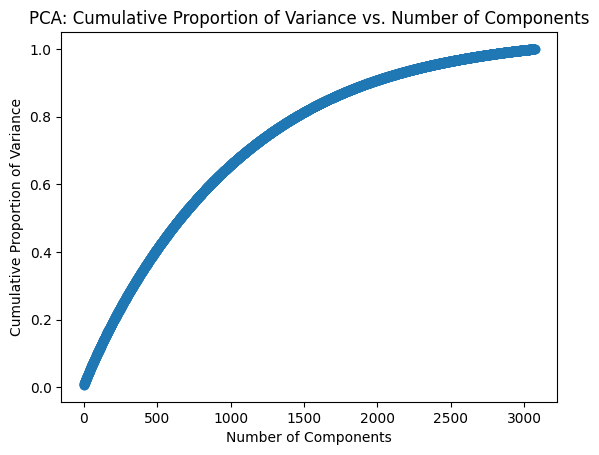

Number of components to keep 90% variance: 1945


In [6]:
# Flatten the data for PCA
X_train_2D = X_train.reshape((X_train.shape[3], -1))

# Standardize the data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_2D)

# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_standardized)

# Cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components to keep for 90% variance
num_components_90 = np.argmax(cumulative_variance >= 0.9) + 1

# Plot PoV against the number of components
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Proportion of Variance')
plt.title('PCA: Cumulative Proportion of Variance vs. Number of Components')
plt.show()

print(f"Number of components to keep 90% variance: {num_components_90}")


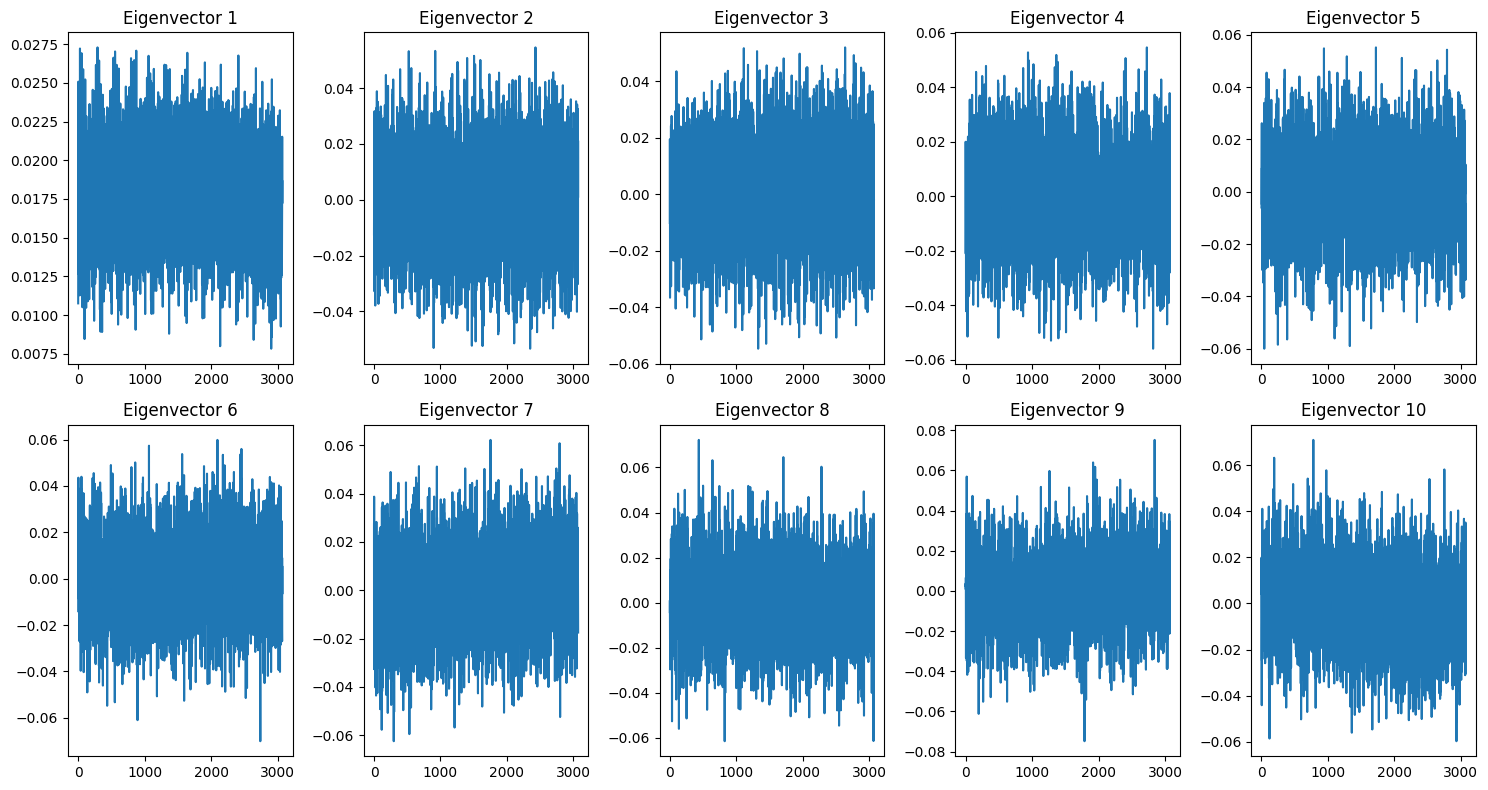

In [10]:
# Assuming top_10_eigenvectors is a 2D array where each row is an eigenvector
top_10_eigenvectors = pca.components_[:10, :]

# Plotting the values along each dimension for the top 10 eigenvectors
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.plot(top_10_eigenvectors[i])
    plt.title(f'Eigenvector {i + 1}')

plt.tight_layout()
plt.show()

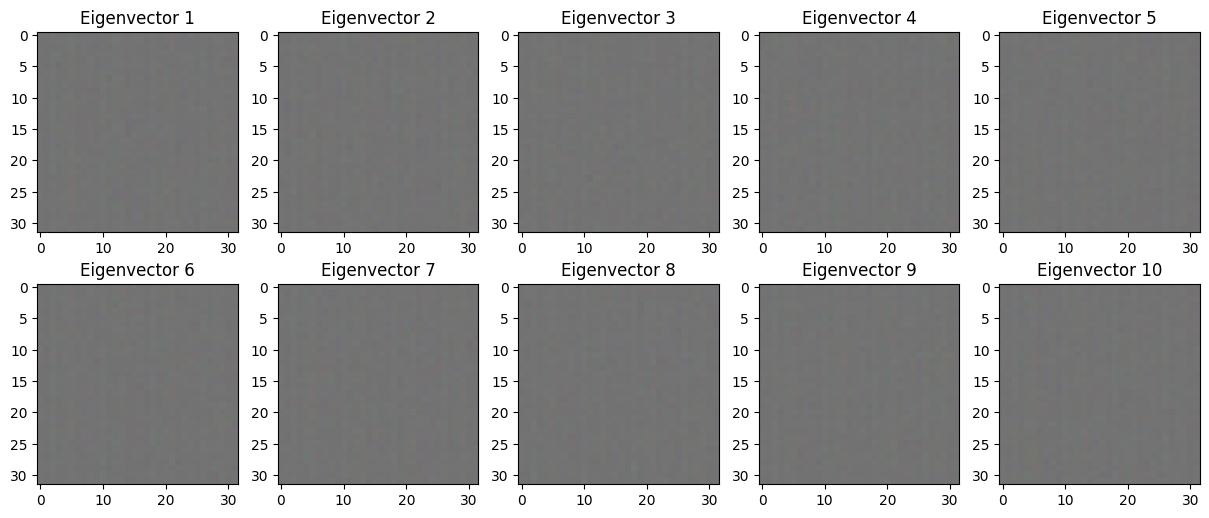

In [35]:



fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Reconstruct the eigenvector in the original space
    reconstructed_eigenvector = scaler.inverse_transform(np.dot(top_10_eigenvectors[i:i+1, :], pca.components_))
    
    # Reshape for plotting
    eigenvector_image = reconstructed_eigenvector.reshape(32, 32, 3)
    ax.imshow(eigenvector_image.astype(int), cmap='viridis')  # Adjust the colormap if needed
    ax.set_title(f'Eigenvector {i + 1}')

plt.show()


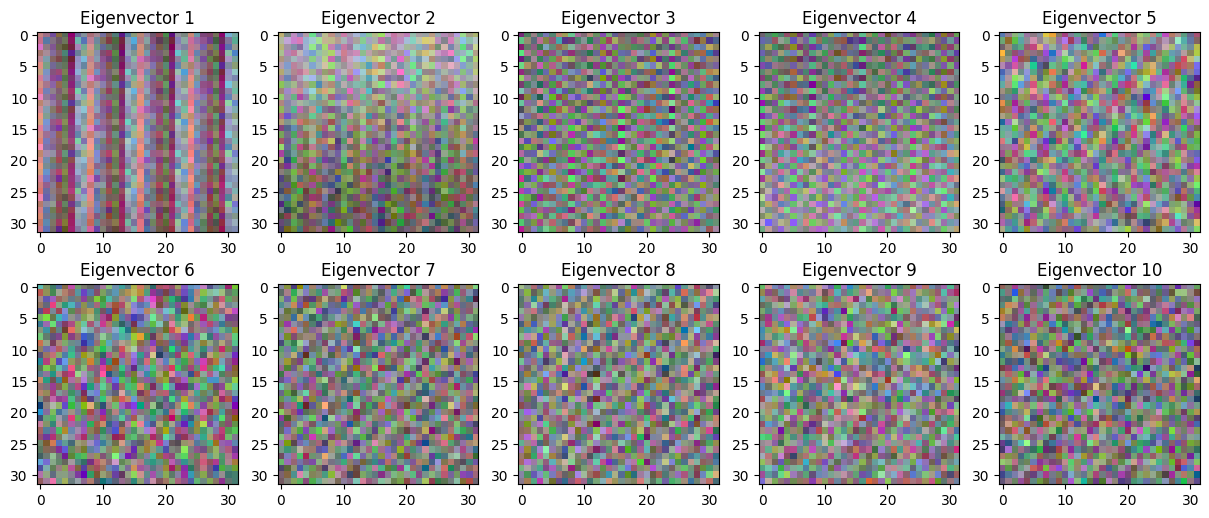

In [36]:


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Reshape eigenvector to image shape
    reshaped_eigenvector = top_10_eigenvectors[i].reshape((32, 32, 3))

    # Convert values to [0, 255] range
    normalized_eigenvector = ((reshaped_eigenvector - reshaped_eigenvector.min()) / 
                              (reshaped_eigenvector.max() - reshaped_eigenvector.min()) * 255)

    # Display the eigenvector as an image
    ax.imshow(normalized_eigenvector.astype(np.uint8), cmap='magma')

    ax.set_title(f'Eigenvector {i + 1}')

plt.show()


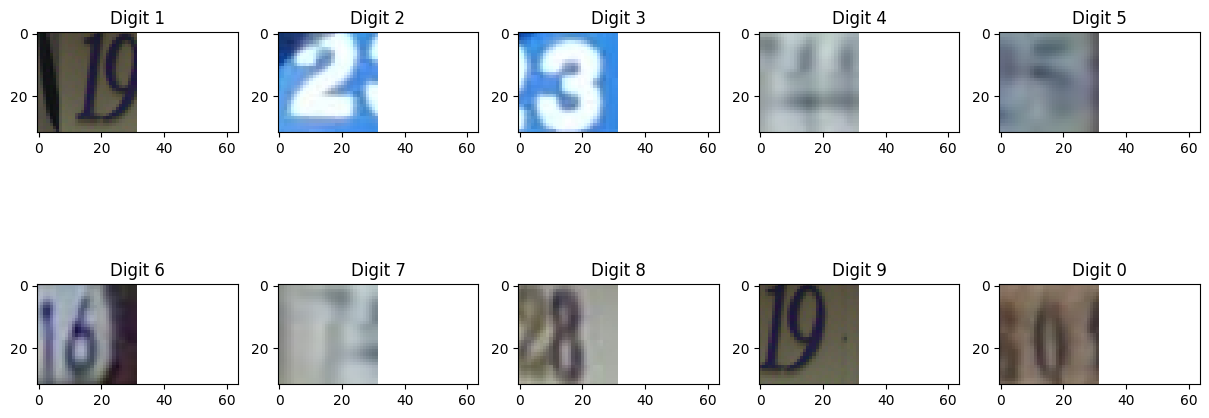

In [18]:
# Define the mapping from class labels to digits
class_to_digit_mapping = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    8: 8,
    9: 9,
    10: 0
}

# Reconstruct 10 SVHN Samples using Top 10 Eigenvectors
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for class_label in range(classes):
    # Select one sample for each class
    sample_indices = np.where(y_train == class_label + 1)[0][:1]

    # Project onto top 10 eigenvectors
    coefficients = np.dot(X_train_standardized[sample_indices], top_10_eigenvectors.T)

    # Reconstruct the sample
    reconstructed_sample = scaler.inverse_transform(np.dot(coefficients, top_10_eigenvectors) + scaler.mean_)

    # Reshape for plotting
    original_sample = X_train[:, :, :, sample_indices].reshape(32, 32, 3)
    reconstructed_sample = reconstructed_sample.reshape(32, 32, 3)

    # Adjust the reconstructed class labels using the mapping
   # Adjust the reconstructed class labels using the mapping
    # Adjust the reconstructed class labels using the mapping
    reconstructed_class_labels = y_train[sample_indices].flatten()
    mapped_reconstructed_labels = [class_to_digit_mapping[int(label)] for label in reconstructed_class_labels]

    # Plot original and reconstructed samples with adjusted labels
    axes[class_label // 5, class_label % 5].imshow(
        np.hstack([np.clip(original_sample, 0, 255), np.clip(reconstructed_sample, 0, 255)]).astype(np.uint8)
    )
    axes[class_label // 5, class_label % 5].set_title(f'Digit {mapped_reconstructed_labels[0]}')


    

plt.show()


In [12]:
print("Shape of X_train_pca[:, :10]:", X_train_pca[:, :10].shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train_pca[:, :10]: (25000, 10)
Shape of y_train: (25000, 1)


In [37]:


# Load the test data
X_test = loadmat('test_32x32.mat')['X']
y_test = loadmat('test_32x32.mat')['y']
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# Reshape the test data to match the shape used during PCA
X_test_flattened = X_test.reshape((X_test.shape[3], -1))

# Standardize the test data using the same scaler used for training
X_test_standardized = scaler.transform(X_test_flattened)

# Flatten the column-vector y
y_test_flat = y_test.flatten()
print("Shape of y_test flat:", y_test_flat.shape)

# Evaluate k-NN classifier for k=5 and k=7 on raw test data
for k in [5, 7]:
    knn_raw = KNeighborsClassifier(n_neighbors=k)
    knn_raw.fit(X_train_standardized, y_train_subset.ravel())
    accuracy_raw = accuracy_score(knn_raw.predict(X_test_standardized), y_test_flat)
    print(f'Accuracy on raw test data for k={k}: {accuracy_raw}')

# Evaluate k-NN classifier on PCA-transformed test data
X_test_pca = pca.transform(X_test_flattened)

# Evaluate k-NN classifier for k=5 and k=7 on PCA-transformed test data
for k in [5, 7]:
    knn_pca = KNeighborsClassifier(n_neighbors=k)
    knn_pca.fit(X_train_pca[:, :num_components_90], y_train_subset.ravel())
    accuracy_pca = accuracy_score(knn_pca.predict(X_test_pca[:, :num_components_90]), y_test_flat)
    print(f'Accuracy on PCA-transformed test data for k={k}: {accuracy_pca}')


Shape of X_test: (32, 32, 3, 26032)
Shape of y_test: (26032, 1)
Shape of y_test flat: (26032,)
Accuracy on raw test data for k=5: 0.06480485556238476
Accuracy on raw test data for k=7: 0.06238475722188076
Accuracy on PCA-transformed test data for k=5: 0.08232175783650891
Accuracy on PCA-transformed test data for k=7: 0.08297480024585126


In [22]:
print("Raw eigenvector:", top_10_eigenvectors[i:i+1, :])



Raw eigenvector: [[-0.03512022  0.00046799 -0.0089476  ...  0.00687552 -0.01605964
   0.00735207]]
